# 손실함수 (Loss Function)

### Huber Loss

In [1]:
import numpy as np

# MSE 손실함수
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# MAE 손실함수
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [2]:
y_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = np.array([1.2, 1.8, 3.1, 3.9, 4.8])

# 큰 값을 붙여줌(이상치) -> MSE와 MAE의 차이가 커짐 
y_true = np.append(y_true, [50.0, 60.0])
y_pred = np.append(y_pred, [10.0, 5.0])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("MSE:", mse)
print("MAE:", mae)

MSE: 660.7342857142858
MAE: 13.685714285714285


In [3]:
# Huber 손실 함수
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss(y_true, y_pred)

np.float64(13.438571428571427)

### 신경망 모델에서 손실 함수 활용

In [4]:
# !pip install scikit-learn

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 생성
X, y = make_classification(
    n_samples=1000,     # 몇개의 샘플
    n_features=20,      # 몇개의 피처
    n_informative=15,   # 라벨 구분에 영향을 주는 개수
    n_redundant=5,      # 중복 개수
    n_classes=2,        # 클래스 개수(이진 분류=2)
    random_state=42 
)

# 전처리 (정규화)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 전처리 (원-핫인코딩)
def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]      # np.eye(num_classes): 단위행렬(identity matrix)를 생성

y_train_oh = one_hot(y_train, 2)
y_test_oh = one_hot(y_test, 2)

In [6]:
X_train.shape   # (750, 20)

(750, 20)

In [7]:
# 모델 파라미터 초기화
np.random.seed(42)

# 차원 정해줌
input_dim = X_train.shape[1]    # 20 피처 개수
hidden_dim = 32
output_dim = 2

# (5, 20) -> ( , 32) -> (720, 32)

# 입력층 -> 은닉층 가중치
W1 = np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))

In [8]:
# 활성화 함수, 손실 함수 정의

# 은닉층의 활성화 함수
def relu(z):
    return np.maximum(0, z)

# 출력층 확률
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# 손실 함수
def cross_entropy_loss(probs, labels):
    m = labels.shape[0]
    log_liklihood = -np.log(probs + 1e-8) * labels
    loss = np.sum(log_liklihood) / m
    return loss

In [9]:
# 학습
learning_rate = 0.01
epochs = 50
train_losses = []
test_losses = []

# 정해진 학습 횟수만큼 반복
for epoch in range(epochs):
    # Forward 순전파
    Z1 = np.dot(X_train, W1) + b1
    R1 = relu(Z1)   # <- 첫번째 은닉층 거침
    Z2 = np.dot(R1, W2) + b2
    probs = softmax(Z2)
    loss = cross_entropy_loss(probs, y_train_oh)
    
    # Backpropagation 역전파
    m = X_train.shape[0]
    dZ2 = (probs - y_train_oh) / m
    dW2 = np.dot(R1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dR1 = np.dot(dZ2, W2.T)
    dZ1 = dR1 * (Z1 > 0)
    dW1 = np.dot(X_train.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # (모델) 파라미터 업데이트
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(loss)
    
    # 테스트 데이터로 손실 확인
    Z1_test = np.dot(X_test, W1) + b1
    R1_test = relu(Z1_test)
    Z2_test = np.dot(R1_test, W2) + b2
    probs_test = softmax(Z2_test)
    loss_test = cross_entropy_loss(probs_test, y_test_oh)
    test_losses.append(loss_test)

    # 학습 결과 손실 출력
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | 학습 손실: {loss:.4f}, 테스트 손실: {loss_test:.4f}")

Epoch 10 | 학습 손실: 4.3756, 테스트 손실: 4.6673
Epoch 20 | 학습 손실: 3.9200, 테스트 손실: 4.2563
Epoch 30 | 학습 손실: 3.5888, 테스트 손실: 3.9074
Epoch 40 | 학습 손실: 3.3203, 테스트 손실: 3.6308
Epoch 50 | 학습 손실: 3.0936, 테스트 손실: 3.3961


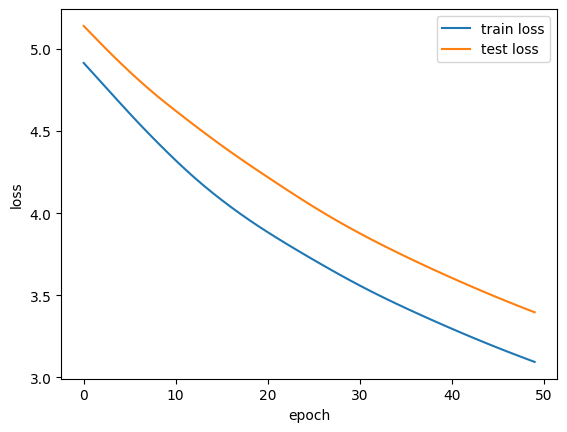

In [10]:
# 학습 곡선 시각화
plt.plot(range(epochs), train_losses, label="train loss")
plt.plot(range(epochs), test_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### 기본 손실 함수 vs 커스텀 손실 함수

In [11]:
from sklearn.datasets import make_regression

# 데이터 생성
X, y = make_regression(
    n_samples=1000,
    n_features=10,
    noise=50,
    random_state=42
)

# 전처리
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()      # .flatten(): 다시 1차원으로

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
# 예측 함수
def predict(X, w, b):
    return np.dot(X, w) + b

In [13]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

# L2 정규화 적용
def my_loss(y_pred, y_true, w, lambda_reg=1.0):
    mse = mse_loss(y_pred, y_true)
    l2_reg = np.sum(w ** 2)
    return mse + (lambda_reg *l2_reg)

In [14]:
def train_model(X_train, y_train, X_test, y_test, loss_fn, epochs=50, learning_rate=0.1, use_custom=False):
    
    np.random.seed(42)
    n_features = X_train.shape[1]
    W = np.random.randn(n_features)
    b = 0.0

    for epoch in range(epochs):
        y_pred_train = predict(X_train, W, b)
        y_pred_test = predict(X_test, W, b)

        train_loss = loss_fn(y_pred_train, y_train, W) if use_custom else loss_fn(y_pred_train, y_train)
        test_loss = loss_fn(y_pred_test, y_test, W) if use_custom else loss_fn(y_pred_test, y_test)

        d_loss = 2 * (y_pred_train - y_train) / X_train.shape[0]
        grad_w = np.dot(X_train.T, d_loss)
        grad_b = np.sum(d_loss)
        
        if use_custom:
            grad_w += 2 * 1.0 * W

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | 학습 손실: {train_loss:.4f} | 테스트 손실: {test_loss:.4f}")

In [15]:
train_model(X_train, y_train, X_test, y_test, my_loss, use_custom=True)

Epoch 10 | 학습 손실: 0.5707 | 테스트 손실: 0.5589
Epoch 20 | 학습 손실: 0.5696 | 테스트 손실: 0.5604
Epoch 30 | 학습 손실: 0.5696 | 테스트 손실: 0.5607
Epoch 40 | 학습 손실: 0.5696 | 테스트 손실: 0.5607
Epoch 50 | 학습 손실: 0.5696 | 테스트 손실: 0.5607


### 손실 함수 선택이 모델 성능에 미치는 영향

In [16]:
# 데이터 생성
X, y = make_regression(
    n_samples=1000,
    n_features=5,
    noise=30,
    random_state=42
)

# 전처리
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()      # .flatten(): 다시 1차원으로

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# 예측 함수
def predict(X, w, b):
    return np.dot(X, w) + b

In [18]:
# MSE 손실함수
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# MAE 손실함수
def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Huber 손실 함수
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

In [19]:
def train_regression(X, y, loss_fn, epochs=100, learning_rate=0.01):
    
    n_features = X.shape[1]
    W = np.random.randn(n_features)
    b = 0.0
    m = X.shape[0]
    epsilon = 1e-5
    losses = []

    for epoch in range(epochs):
        y_pred = predict(X, W, b)
        loss = loss_fn(y_pred, y)
        losses.append(loss)

        grad_w = np.zeros_like(W)
        for i in range(len(W)):
            W_eps = np.copy(W)
            W_eps[i] += epsilon
            loss_eps = loss_fn(predict(X, W_eps, b), y)
            grad_w[i] = (loss_eps - loss) / epsilon

        b_eps = b + epsilon
        loss_eps_b = loss_fn(predict(X, W, b_eps), y)
        grad_b = (loss_eps_b - loss) / epsilon

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

    return W, b, losses

In [20]:
results = {}

for name, loss_fn in zip(["MSE", "MAE", "Huber"], [mse_loss, mae_loss, huber_loss]):
    W, b, losses = train_regression(X_train, y_train, loss_fn)
    results[name] = {"losses": losses}

    pred_test = predict(X_test, W, b)
    test_loss = mse_loss(pred_test, y_test)
    print(f"{name} Loss: {test_loss:.4f}")

MSE Loss: 0.4267
MAE Loss: 4.5130
Huber Loss: 2.8584


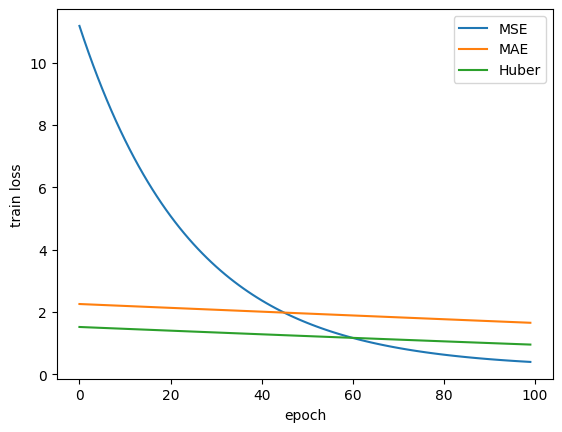

In [21]:
# 시각화
for name, value in results.items():
    plt.plot(value["losses"], label=name)

plt.xlabel("epoch")
plt.ylabel("train loss")
plt.legend()
plt.show()

# 어떤 손실 함수를 쓰느냐에 따라 모델 성능이 달라진다.
# 언제나 MSE가 성능이 잘 나온다 XX